# Baseline model for single step

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
d_data = pd.read_csv("../data/clean/df_41017.csv")

In [3]:
d_data.date = pd.to_datetime(d_data.date)

In [4]:
d_test = d_data[d_data.date > pd.to_datetime("2016/01/01")]

In [5]:
d_train = d_data[d_data.date < pd.to_datetime("2016/01/01")]

In [6]:
swh_arr = d_train.swh.values

In [7]:
swh_arr.shape

(24121,)

In [8]:
rows = swh_arr.shape[0] - 6

In [9]:
dataset = np.zeros((rows+1, 6))

In [10]:
for idx, start in enumerate(range(0, len(swh_arr) - 5)):
    row = swh_arr[start:start+6]
    dataset[idx, :] = row

In [11]:
dataset

array([[2.15, 2.18, 2.32, 2.47, 2.31, 2.37],
       [2.18, 2.32, 2.47, 2.31, 2.37, 2.25],
       [2.32, 2.47, 2.31, 2.37, 2.25, 2.25],
       ...,
       [2.64, 2.44, 2.85, 2.7 , 2.64, 2.56],
       [2.44, 2.85, 2.7 , 2.64, 2.56, 2.48],
       [2.85, 2.7 , 2.64, 2.56, 2.48, 2.63]])

In [12]:
dataset.shape

(24116, 6)

In [13]:
dataset_nona = dataset[~np.isnan(dataset).any(axis=1)]

In [14]:
dataset_nona

array([[2.15, 2.18, 2.32, 2.47, 2.31, 2.37],
       [2.18, 2.32, 2.47, 2.31, 2.37, 2.25],
       [2.32, 2.47, 2.31, 2.37, 2.25, 2.25],
       ...,
       [2.64, 2.44, 2.85, 2.7 , 2.64, 2.56],
       [2.44, 2.85, 2.7 , 2.64, 2.56, 2.48],
       [2.85, 2.7 , 2.64, 2.56, 2.48, 2.63]])

In [15]:
dataset_nona.shape

(22455, 6)

### Modeling

In [16]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, make_scorer

In [17]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=True)

In [18]:
rmse_score = make_scorer(rmse, greater_is_better=False)

In [19]:
X = dataset_nona[:, :5]
y = dataset_nona[:, 5]

In [ ]:
X

In [ ]:
y

Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
model = SVR()

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_pred, squared=True)

KFold

In [ ]:
folds = KFold(n_splits=5).split(np.arange(0, len(X)))

In [ ]:
scores = np.zeros(5)

In [ ]:
for idx, (train, test) in enumerate(folds):
    X_train, y_train = X[train], y[train]
    X_test, y_test = X[test], y[test]
    
    model = SVR()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=True)
    scores[idx] = rmse

In [ ]:
scores.mean(), scores.std()

Inference with latest data split

In [ ]:
model = SVR()

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_true_pred = np.concatenate((y_test.reshape(-1, 1), y_pred.reshape(-1,1)), axis=1)

In [ ]:
pd.DataFrame(data=y_true_pred, columns=['true', 'pred'])

### Multi time steps

#### fitmodel

In [20]:
model = SVR()

In [21]:
model.fit(X, y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [22]:
d_test.isna().sum()

date      0
swh     126
dtype: int64

#### handle missing values using interpolate 

In [24]:
d_test = d_test.interpolate()

In [81]:
start = d_test.swh.values[:5]

In [82]:
start = np.expand_dims(start, 0)

In [83]:
start

array([[2.59, 2.71, 2.88, 2.83, 3.11]])

In [84]:
y_test_pred = start.copy()

In [85]:
y_test_pred

array([[2.59, 2.71, 2.88, 2.83, 3.11]])

In [86]:
iterate = d_test.shape[0] - 5

In [87]:
for _ in range(iterate):
    out = model.predict(start)
    # only 2 decimals
    out = np.round(out, 2)
    # append to start
    start = np.append(start, out)
    start = np.expand_dims(np.delete(start, 0), 0)
    # append to test pred
    y_test_pred = np.append(y_test_pred, out)

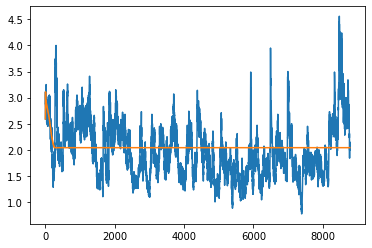

In [88]:
plt.plot(d_test.swh.values)
plt.plot(y_test_pred)

In [92]:
mean_squared_error(d_test.swh, y_test_pred)

0.26918843504497325

In [93]:
mean_squared_error(d_test.swh, y_test_pred, squared=False)

0.5188337258168297